In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import shutil
import glob
import time
from PIL import Image
from tqdm import tqdm

### Read

In [2]:
#Read dataframe
#data = pd.read_pickle("data_l_parrots.pkl")
data = pd.read_pickle("data_l_exc_0_on.pkl")
#data = pd.read_pickle("data_l_inh_0_on.pkl")
#data = pd.read_pickle("data.pkl")

data = data.sort_values(by=['Time'])
data = data.set_index([pd.Index([i for i in range(len(data))])])
data;

In [3]:
#Create folder
new_path = 'plots_folder' 
if not os.path.exists(new_path):
    os.makedirs(new_path)

In [4]:
#Remove contents of the plots folder
for filename in os.listdir(new_path):
    file_path = os.path.join(new_path, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
    except Exception as e:
        print('Failed to delete %s. Reason: %s' % (file_path, e))

### Generate frames

In [5]:
t = time.time()
window_time = 1
x_cortex_size = 20
y_cortex_size = 20
re_size = (200,200)
array = [0] * x_cortex_size * y_cortex_size
neurons_per_column_exc = 1

times = data['Time'].tolist() 
times = (np.around(data['Time'],window_time)).tolist()
actual_time = times[0]

x_pos = (np.around(data['x_pos'] * x_cortex_size + x_cortex_size/2 - 0.5)).astype(int).tolist()
y_pos = (np.around(data['y_pos'] * y_cortex_size + x_cortex_size/2 - 0.5)).astype(int).tolist()

num_spikes = len(data)

for i in tqdm(range(0,num_spikes)): 
    if times[i] - actual_time != 0 or i == num_spikes:
        name = new_path+'/plot_time_'+str(actual_time)+'.tiff'

        array = np.reshape(array,(x_cortex_size,y_cortex_size))
        img = Image.fromarray(np.uint8(array) , 'L').resize(re_size).transpose(Image.FLIP_TOP_BOTTOM).save(name, compress_level = 1)

        actual_time = times[i]
        array = [0] * x_cortex_size * y_cortex_size

    array[ x_pos[i] + y_cortex_size * y_pos[i] ] += 1 #/ neurons_per_column_exc

100%|██████████| 161906/161906 [00:10<00:00, 15625.07it/s]


In [6]:
del(data)

### Create Video and Average Image

In [7]:
frames = np.unique(np.array(times)).tolist()
img_array = []

for milisecond in tqdm(frames[:-1]):
    filename = new_path + '/plot_time_' + str(milisecond)+'.tiff'
    img = cv2.imread(filename,cv2.IMREAD_GRAYSCALE)
    img_array.append(img)

size = (img.shape[0],img.shape[1])
video_out = cv2.VideoWriter('neurons_video.avi',cv2.VideoWriter_fourcc(*'DIVX'), 30, size,0 )

max_array = np.max(img_array)
for i in tqdm(range(len(img_array))):
    to_write = 255 * img_array[i] / max_array
    video_out.write( to_write.astype(np.uint8) )

video_out.release()

100%|██████████| 9969/9969 [00:07<00:00, 1263.68it/s]


### Average image 

In [8]:
img_sum = np.zeros(re_size)
for i in tqdm(range(0,len(img_array))):
    img_sum = img_sum + np.divide(img_array[i],len(img_array)*neurons_per_column_exc)

100%|██████████| 9969/9969 [00:01<00:00, 6750.92it/s]


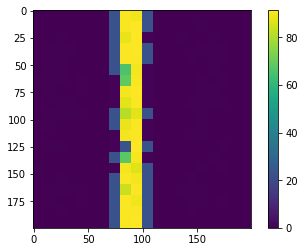

In [11]:
plt.imshow(img_sum)
plt.colorbar()
plt.show()
del(img_sum);del(avg_img_array);del(img_array)

### EEG

In [10]:
from collections import Counter
simulation_time = 1000.0

In [11]:
counts = Counter(times)
eeg = list(counts.values())

In [12]:
sum(eeg)

161906

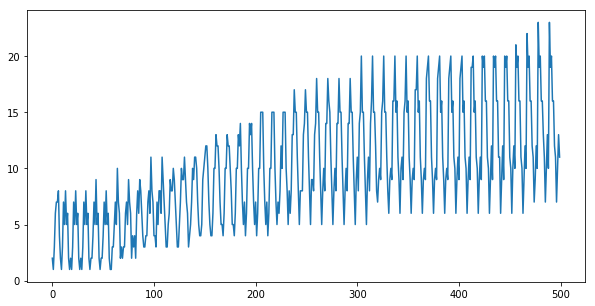

In [13]:
plt.figure(figsize = (10,5));
plt.plot(eeg[0:500]);

### Fourier Transform and frequencies

In [14]:
from scipy.fft import fft, fftfreq

In [15]:
fourier_transform = fft(np.asarray(eeg))

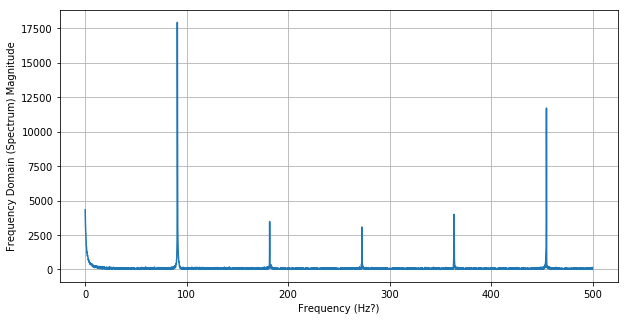

In [16]:
# Number of sample points
N = len(fourier_transform)
# sample spacing
T = 1.0 / simulation_time
x_points = fftfreq(N, T)[:N//2]

plt.figure(figsize = (10,5));

#plt.plot(x_points, np.abs(fourier_transform[0:N//2]) / np.max(np.abs(fourier_transform) ))
#plt.plot(x_points, np.abs(fourier_transform[0:N//2]) )
#plt.plot(x_points[1:], np.abs(fourier_transform[1:N//2]) / np.max(np.abs(fourier_transform[1:]) ))
plt.plot(x_points[1:], np.abs(fourier_transform[1:N//2]) )
plt.xlabel("Frequency (Hz?)")
plt.ylabel("Frequency Domain (Spectrum) Magnitude")
plt.grid()
plt.show()

In [17]:
img = cv2.imread(filename,cv2.IMREAD_GRAYSCALE)

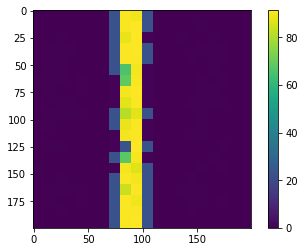

In [18]:
plt.imshow(img_sum)
plt.colorbar()
plt.show()

In [22]:
np.max( 255 * img_array[4]  / np.max(img_array))

5.0